<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

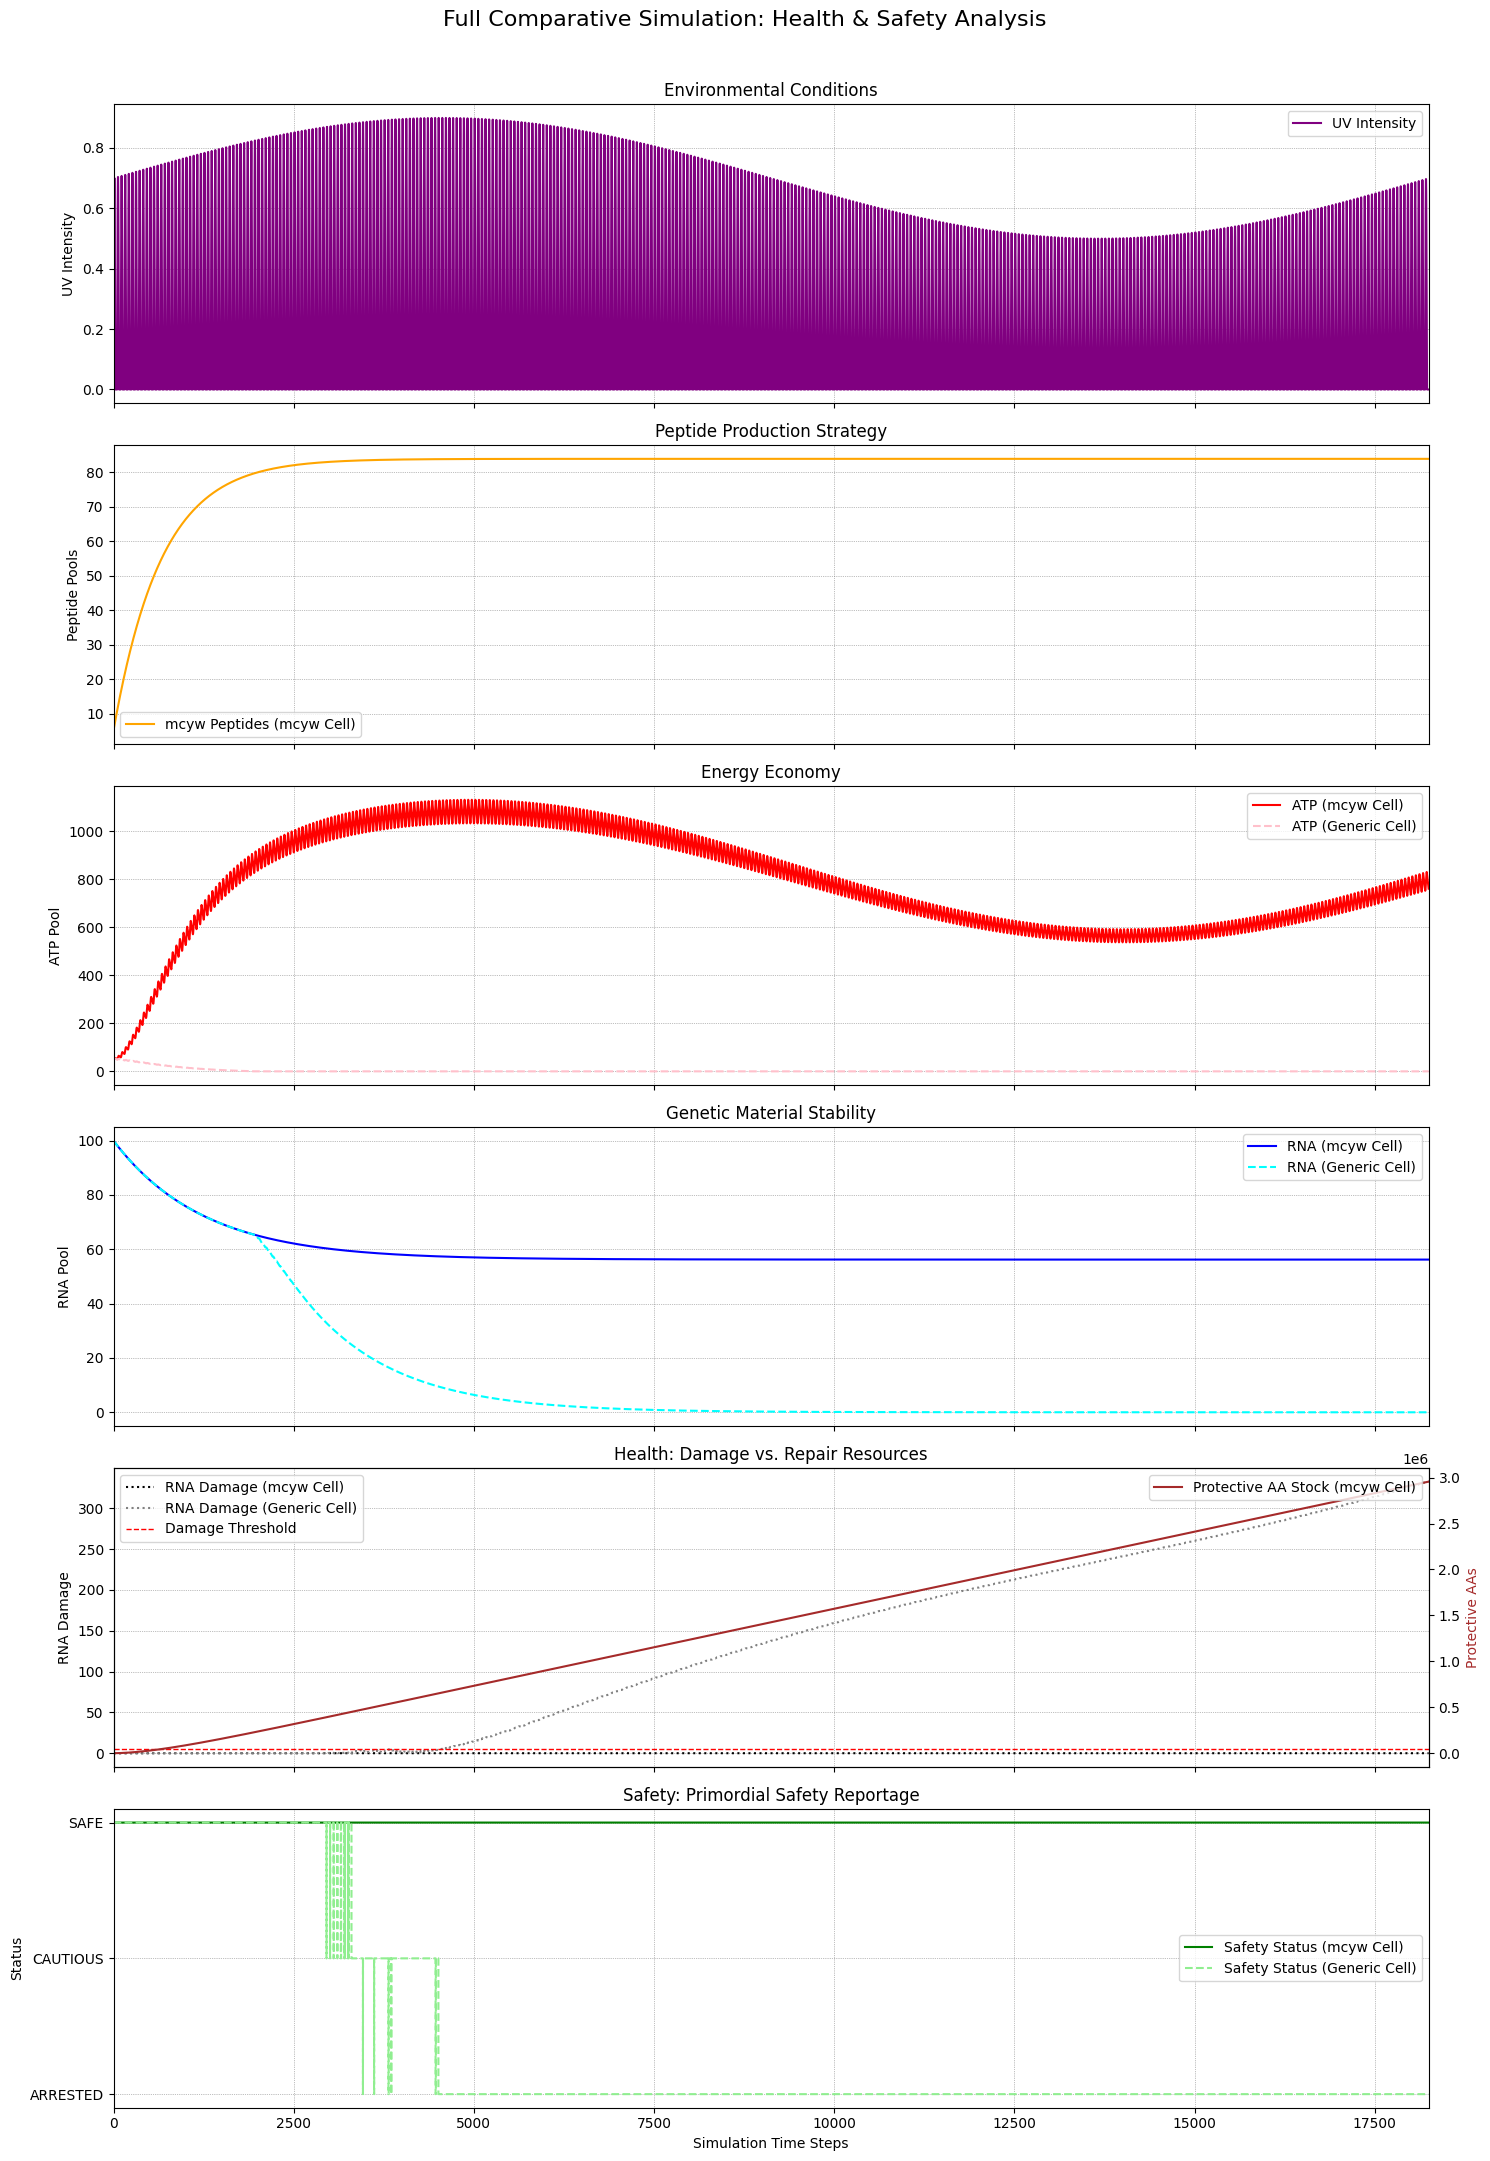

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Environment Class (Unchanged) ---
class Environment:
    def __init__(self, total_sim_steps, days_per_cycle=50):
        self.total_sim_steps = total_sim_steps
        self.days_per_cycle = days_per_cycle
        self.time = 0
        daily_uv_cycle = np.sin(np.linspace(0, 2 * np.pi, days_per_cycle))
        daily_uv_cycle[daily_uv_cycle < 0] = 0
        seasonal_amplitude_mod = 0.2 * np.sin(np.linspace(0, 2 * np.pi * (total_sim_steps / (365 * days_per_cycle)), total_sim_steps)) + 0.7
        self.uv_intensity = np.zeros(total_sim_steps)
        for i in range(total_sim_steps):
            self.uv_intensity[i] = daily_uv_cycle[i % days_per_cycle] * seasonal_amplitude_mod[i]
        self.external_ntp_pool = 10000.0
        self.external_aa_pool = 10000.0
        self.external_trp_tyr_cys_pool = 500.0
    def get_current_uv(self):
        return self.uv_intensity[self.time] if self.time < self.total_sim_steps else 0.0
    def step(self):
        self.time += 1

# --- 2. Proto-Cell Class (Unchanged from last correct version) ---
class ProtoCell:
    def __init__(self, env, strategy='mcyw'):
        self.env, self.strategy = env, strategy
        self.rna_pool, self.dna_pool, self.atp_pool = 100.0, 10.0, 50.0
        self.mcyw_peptide_pool, self.other_peptide_pool = 5.0, 2.0
        self.internal_ntp_stock, self.internal_aa_stock, self.internal_trp_tyr_cys_stock = 100.0, 100.0, 10.0
        self.rna_damage_level, self.protein_synthesis_active, self.rna_dna_copying_active = 0.0, True, True
        self.uv_safety_status, self.premature_stop_signal = "SAFE", 0.0
        self.mcyw_synthesis_bias = 0.7 if self.strategy == 'mcyw' else 0.0
        self.damage_tolerance_threshold = 5.0; self.uv_damage_rate_per_uv = 0.12
        self.atp_generation_rate_per_mcyw_uv = 0.15; self.repair_rate = 0.6
        self.repair_atp_cost = 0.007; self.foraging_efficiency_mcyw = 0.20
        self.foraging_atp_cost = 0.003; self.trp_tyr_cys_foraging_bias = 10.0
        self.protein_synthesis_rate = 0.18; self.protein_synthesis_ntp_cost = 0.1
        self.protein_synthesis_aa_cost = 0.1; self.protein_synthesis_atp_cost = 0.02
        self.precarious_codon_rate_per_damage = 0.3; self.premature_stop_signal_threshold = 0.35
        self.trp_tyr_cys_for_repair_needed = 0.05; self.rna_dna_copy_rate = 0.05
        self.rna_dna_copy_ntp_cost = 0.05; self.rna_dna_copy_atp_cost = 0.01
        self.rna_degradation_rate = 0.0008; self.peptide_degradation_rate = 0.0015
        self.atp_degradation_rate = 0.003
    def _apply_uv_damage(self):
        uv = self.env.get_current_uv()
        if uv > 0: self.rna_damage_level += uv * self.uv_damage_rate_per_uv; self.premature_stop_signal = (uv * self.uv_damage_rate_per_uv) * self.precarious_codon_rate_per_damage
        else: self.premature_stop_signal = 0
    def _forage(self):
        if self.mcyw_peptide_pool > 0 and self.atp_pool > self.foraging_atp_cost:
            self.atp_pool -= self.foraging_atp_cost * self.mcyw_peptide_pool
            foraged = self.foraging_efficiency_mcyw * self.mcyw_peptide_pool
            self.internal_ntp_stock += min(foraged/2, self.env.external_ntp_pool)
            self.internal_aa_stock += min(foraged/2, self.env.external_aa_pool)
            self.internal_trp_tyr_cys_stock += min(foraged * self.trp_tyr_cys_foraging_bias, self.env.external_trp_tyr_cys_pool)
    def _synthesize_protein(self):
        if not self.protein_synthesis_active: return
        units = self.protein_synthesis_rate
        if not (self.internal_ntp_stock >= units*self.protein_synthesis_ntp_cost and self.internal_aa_stock >= units*self.protein_synthesis_aa_cost and self.atp_pool >= units*self.protein_synthesis_atp_cost): return
        m_units = min(units * self.mcyw_synthesis_bias, self.internal_trp_tyr_cys_stock / (self.protein_synthesis_aa_cost * self.mcyw_synthesis_bias)) if self.mcyw_synthesis_bias > 0 else 0
        self.mcyw_peptide_pool += m_units
        self.other_peptide_pool += units - m_units
        self.internal_trp_tyr_cys_stock -= m_units * (self.protein_synthesis_aa_cost * self.mcyw_synthesis_bias)
        self.internal_ntp_stock -= units*self.protein_synthesis_ntp_cost
        self.internal_aa_stock -= units*self.protein_synthesis_aa_cost
        self.atp_pool -= units*self.protein_synthesis_atp_cost
    def _synthesize_atp(self):
        if self.env.get_current_uv() > 0 and self.mcyw_peptide_pool > 0: self.atp_pool += self.atp_generation_rate_per_mcyw_uv * self.mcyw_peptide_pool * self.env.get_current_uv()
    def _repair_rna_dna(self):
        if self.rna_damage_level > 0 and self.atp_pool >= self.repair_atp_cost and self.internal_trp_tyr_cys_stock >= self.trp_tyr_cys_for_repair_needed:
            self.atp_pool -= self.repair_atp_cost; self.internal_trp_tyr_cys_stock -= self.trp_tyr_cys_for_repair_needed
            self.rna_damage_level -= min(self.rna_damage_level, self.repair_rate)
    def _copy_rna_dna(self):
        if not self.rna_dna_copying_active or not (self.internal_ntp_stock >= self.rna_dna_copy_ntp_cost and self.atp_pool >= self.rna_dna_copy_atp_cost): return
        self.internal_ntp_stock -= self.rna_dna_copy_ntp_cost; self.atp_pool -= self.rna_dna_copy_atp_cost
        self.rna_pool += self.rna_dna_copy_rate * 0.9; self.dna_pool += self.rna_dna_copy_rate * 0.1
    def _degrade(self):
        for pool in ['rna_pool', 'dna_pool', 'mcyw_peptide_pool', 'other_peptide_pool', 'atp_pool']:
            rate = self.rna_degradation_rate if 'rna' in pool or 'dna' in pool else (self.peptide_degradation_rate if 'peptide' in pool else self.atp_degradation_rate)
            setattr(self, pool, getattr(self, pool) * (1 - rate))
    def _manage_state(self):
        norm_dmg = min(1.0, self.rna_damage_level / self.damage_tolerance_threshold)
        scarcity = 1.0 - (self.internal_trp_tyr_cys_stock / (self.trp_tyr_cys_for_repair_needed*5)) if self.internal_trp_tyr_cys_stock < self.trp_tyr_cys_for_repair_needed*5 and self.env.get_current_uv() > 0.1 else 0.0
        danger = (norm_dmg * 0.4) + (max(0,min(1,scarcity)) * 0.4) + (self.premature_stop_signal * 0.2)
        if danger >= self.premature_stop_signal_threshold: self.protein_synthesis_active, self.rna_dna_copying_active, self.uv_safety_status = False, False, "ARRESTED"
        elif danger < self.premature_stop_signal_threshold*0.2: self.protein_synthesis_active, self.rna_dna_copying_active, self.uv_safety_status = True, True, ("SAFE" if danger < self.premature_stop_signal_threshold*0.1 and self.internal_trp_tyr_cys_stock > self.trp_tyr_cys_for_repair_needed*10 else "CAUTIOUS")
        else: self.uv_safety_status = "CAUTIOUS"
    def step(self):
        [getattr(self, p)() for p in ['_apply_uv_damage', '_synthesize_atp', '_forage', '_repair_rna_dna', '_manage_state', '_synthesize_protein', '_copy_rna_dna', '_degrade']]

# --- 3. Simulation Runner (Modified to collect more data) ---
def run_simulation(total_steps, days_per_cycle):
    env = Environment(total_steps, days_per_cycle)
    cell_mcyw, cell_generic = ProtoCell(env, strategy='mcyw'), ProtoCell(env, strategy='generic')
    # ADDED new keys for health and safety
    data_keys = ['rna_pool', 'atp_pool', 'mcyw_peptide_pool', 'rna_damage_level', 'internal_trp_tyr_cys_stock', 'uv_safety_status']
    data = {'time': [], 'uv_intensity': []}
    for key in data_keys:
        for cell_type in ['mcyw', 'generic']: data[f'{key}_{cell_type}'] = []
    for _ in range(total_steps):
        data['time'].append(env.time); data['uv_intensity'].append(env.get_current_uv())
        cell_mcyw.step(); cell_generic.step()
        for key in data_keys:
            for cell_type, cell_obj in [('mcyw', cell_mcyw), ('generic', cell_generic)]:
                data[f'{key}_{cell_type}'].append(getattr(cell_obj, key))
        env.step()
    return pd.DataFrame(data)

# --- 4. Main Execution and Visualization (Modified for 6 plots) ---
if __name__ == "__main__":
    SIMULATION_DAYS = 365; STEPS_PER_DAY = 50; TOTAL_STEPS = SIMULATION_DAYS * STEPS_PER_DAY
    results_df = run_simulation(total_steps=TOTAL_STEPS, days_per_cycle=STEPS_PER_DAY)

    fig, axs = plt.subplots(6, 1, figsize=(15, 22), sharex=True)
    fig.suptitle('Full Comparative Simulation: Health & Safety Analysis', fontsize=16)

    # Plot 1: Environment
    axs[0].plot(results_df['time'], results_df['uv_intensity'], color='purple', label='UV Intensity')
    axs[0].set_title('Environmental Conditions'); axs[0].set_ylabel('UV Intensity'); axs[0].legend()

    # Plot 2: Peptide Production
    axs[1].plot(results_df['time'], results_df['mcyw_peptide_pool_mcyw'], label='mcyw Peptides (mcyw Cell)', color='orange')
    axs[1].set_title('Peptide Production Strategy'); axs[1].set_ylabel('Peptide Pools'); axs[1].legend()

    # Plot 3: Energy Economy
    axs[2].plot(results_df['time'], results_df['atp_pool_mcyw'], label='ATP (mcyw Cell)', color='red')
    axs[2].plot(results_df['time'], results_df['atp_pool_generic'], label='ATP (Generic Cell)', color='pink', linestyle='--')
    axs[2].set_title('Energy Economy'); axs[2].set_ylabel('ATP Pool'); axs[2].legend()

    # Plot 4: Genetic Material
    axs[3].plot(results_df['time'], results_df['rna_pool_mcyw'], label='RNA (mcyw Cell)', color='blue')
    axs[3].plot(results_df['time'], results_df['rna_pool_generic'], label='RNA (Generic Cell)', color='cyan', linestyle='--')
    axs[3].set_title('Genetic Material Stability'); axs[3].set_ylabel('RNA Pool'); axs[3].legend()

    # Plot 5: RNA Damage & Protective Resources (Health)
    ax5_twin = axs[4].twinx()
    axs[4].plot(results_df['time'], results_df['rna_damage_level_mcyw'], label='RNA Damage (mcyw Cell)', color='black', linestyle=':')
    axs[4].plot(results_df['time'], results_df['rna_damage_level_generic'], label='RNA Damage (Generic Cell)', color='grey', linestyle=':')
    axs[4].axhline(y=ProtoCell(Environment(1)).damage_tolerance_threshold, color='red', linestyle='--', linewidth=1, label='Damage Threshold')
    ax5_twin.plot(results_df['time'], results_df['internal_trp_tyr_cys_stock_mcyw'], label='Protective AA Stock (mcyw Cell)', color='brown')
    axs[4].set_ylabel('RNA Damage'); ax5_twin.set_ylabel('Protective AAs', color='brown'); axs[4].set_title('Health: Damage vs. Repair Resources')
    axs[4].legend(loc='upper left'); ax5_twin.legend(loc='upper right')

    # Plot 6: UV Safety Status (Safety)
    status_map = {"SAFE": 1, "CAUTIOUS": 0.5, "ARRESTED": 0}
    axs[5].plot(results_df['time'], results_df['uv_safety_status_mcyw'].map(status_map), label='Safety Status (mcyw Cell)', color='green', drawstyle='steps-post')
    axs[5].plot(results_df['time'], results_df['uv_safety_status_generic'].map(status_map), label='Safety Status (Generic Cell)', color='lightgreen', linestyle='--', drawstyle='steps-post')
    axs[5].set_yticks([0, 0.5, 1]); axs[5].set_yticklabels(["ARRESTED", "CAUTIOUS", "SAFE"])
    axs[5].set_title('Safety: Primordial Safety Reportage'); axs[5].set_ylabel('Status'); axs[5].legend()

    for ax in axs: ax.grid(True, linestyle=':', linewidth='0.5', color='gray'); ax.set_xlim(0, TOTAL_STEPS)
    axs[5].set_xlabel('Simulation Time Steps')
    plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()
